In [5]:
%pip install matplotlib numpy requests pandas seaborn tensorflow pydot

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [7]:
url = (
    "https://archive-api.open-meteo.com/v1/archive"
    "?latitude=30.4202&longitude=-9.5982"
    "&start_date=2000-01-01&end_date=2025-05-19"
    "&hourly=temperature_2m,dewpoint_2m,relative_humidity_2m,precipitation,pressure_msl,windspeed_10m,cloudcover"
    "&timezone=auto"
)

data = requests.get(url).json()
df = pd.DataFrame(data["hourly"])
df.to_csv("agadir_weather.csv", index=False)


In [8]:
df = pd.read_csv("agadir_weather.csv")

In [9]:
df['datetime_utc'] = pd.to_datetime(df['time'])

In [10]:
# imputing the missing value in temperature feature with mean.
df['temperature_2m'].fillna(df['temperature_2m'].mean(), inplace=True)

In [11]:
df['temperature_2m'].isna().sum()
# filled all missing values with mean()

0

In [12]:
str(df['datetime_utc'][0])

'2000-01-01 00:00:00'

In [13]:
# a function to extract year part from the whole date
def get_year(x):
  return x[0:4]

In [14]:
# a function to extract month part from the whole date
def get_month(x):
  return x[5:7]

In [15]:
# making two new features year and month
df['year'] = df['datetime_utc'].apply(lambda x: get_year(str(x)))
df['month'] = df['datetime_utc'].apply(lambda x: get_month(str(x)))

In [16]:
df['year']

0         2000
1         2000
2         2000
3         2000
4         2000
          ... 
222499    2025
222500    2025
222501    2025
222502    2025
222503    2025
Name: year, Length: 222504, dtype: object

In [17]:
temp_year = pd.crosstab(df['year'], df['month'], values=df['temperature_2m'], aggfunc='mean')

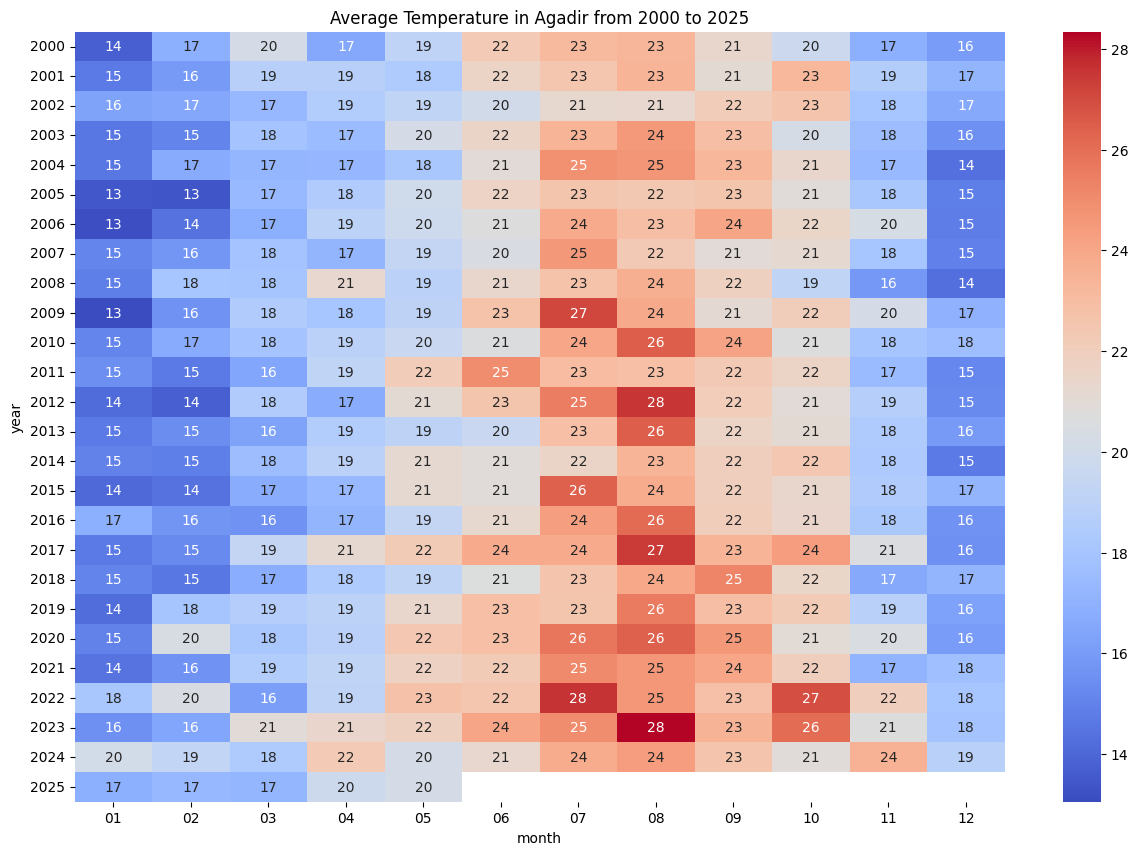

In [18]:
plt.figure(figsize=(15, 10))
sns.heatmap(temp_year, cmap='coolwarm', annot=True)
plt.title("Average Temperature in Agadir from 2000 to 2025")
plt.show()

In [19]:
df.rename(columns={
    "temperature_2m": "_tempm",
}, inplace=True)

In [20]:
df.head()

,time,_tempm,dewpoint_2m,relative_humidity_2m,precipitation,pressure_msl,windspeed_10m,cloudcover,datetime_utc,year,month
0,2000-01-01T00:00,14.6,13.1,91,0.0,1019.7,5.1,0,2000-01-01 00:00:00,2000,01
1,2000-01-01T01:00,15.0,13.3,90,0.0,1019.9,4.3,0,2000-01-01 01:00:00,2000,01
2,2000-01-01T02:00,13.3,12.1,92,0.0,1019.8,5.4,7,2000-01-01 02:00:00,2000,01
3,2000-01-01T03:00,11.5,10.6,94,0.0,1019.5,6.6,29,2000-01-01 03:00:00,2000,01
4,2000-01-01T04:00,11.0,9.8,92,0.0,1019.7,7.1,9,2000-01-01 04:00:00,2000,01


In [21]:
# taking only temperature feature as values and datetime feature as index in the dataframe for time series forecasting of temperature
data = pd.DataFrame(list(df['_tempm']), index=df['datetime_utc'], columns=['temp'])

In [22]:
data

,temp
datetime_utc,
2000-01-01 00:00:00,14.6
2000-01-01 01:00:00,15.0
2000-01-01 02:00:00,13.3
2000-01-01 03:00:00,11.5
2000-01-01 04:00:00,11.0
...,...
2025-05-19 19:00:00,24.0
2025-05-19 20:00:00,21.0
2025-05-19 21:00:00,19.2


In [23]:
# resampling data with date frequency for time series forecasting
data = data.resample('D').mean()

In [24]:
data.temp.isna().sum()

0

In [25]:
data.fillna(data['temp'].mean(), inplace=True)

In [26]:
data.temp.isna().sum()

0

In [27]:
data.shape

(9271, 1)

In [28]:
data

,temp
datetime_utc,
2000-01-01,14.308333
2000-01-02,13.766667
2000-01-03,13.241667
2000-01-04,13.075000
2000-01-05,12.462500
...,...
2025-05-15,22.550000
2025-05-16,22.500000
2025-05-17,20.504167


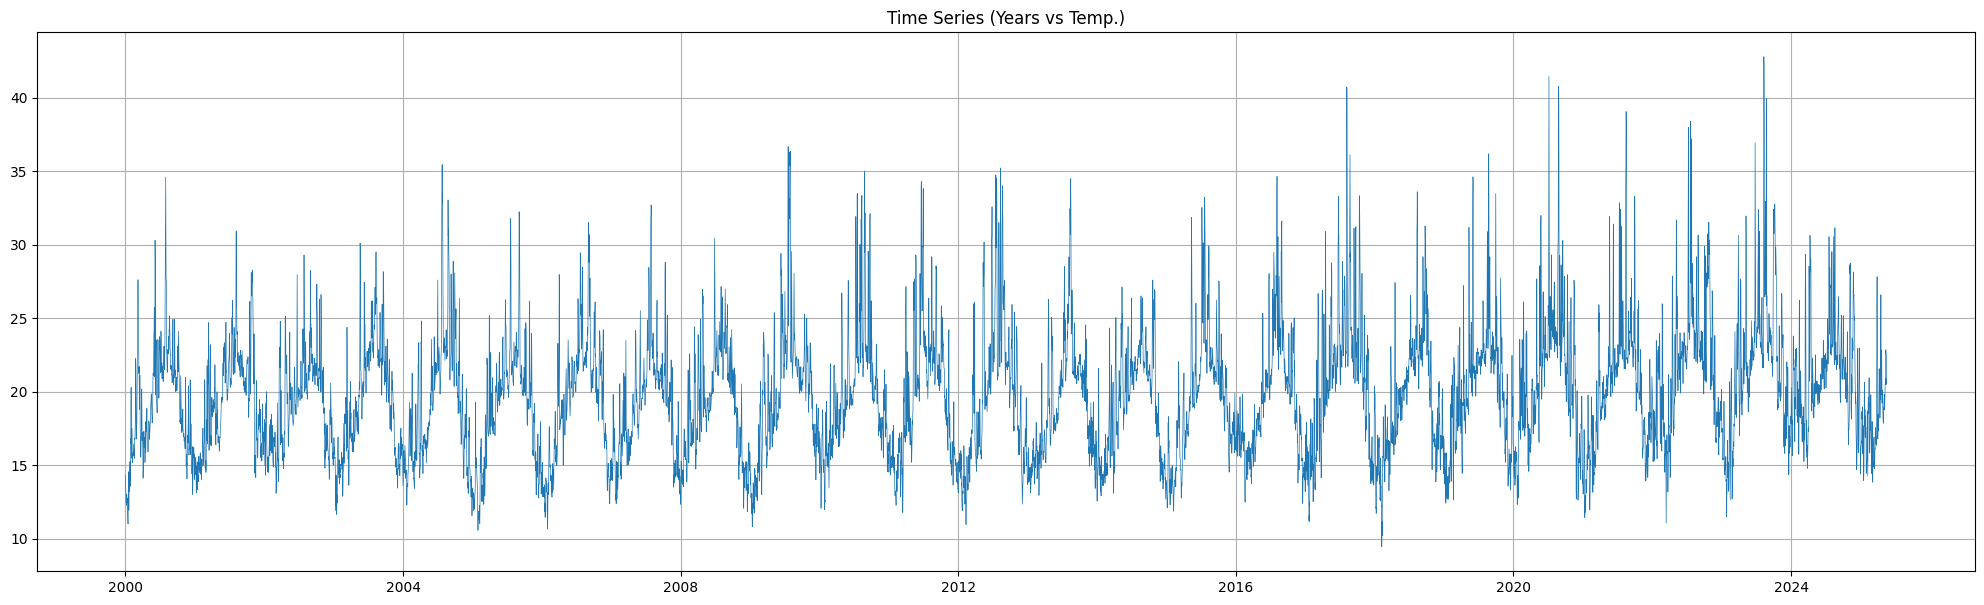

In [29]:
plt.figure(figsize=(25, 7))
plt.plot(data, linewidth=.5)
plt.grid()
plt.title("Time Series (Years vs Temp.)")
plt.show()

In [30]:
# Scaling data to get rid of outliers
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled = scalar.fit_transform(data)

In [31]:
data_scaled

array([[-0.70889083],
       [-0.74140303],
       [-0.77291484],
       ...,
       [-0.33700138],
       [-0.31849444],
       [-0.33099912]])

In [32]:
data_scaled.shape

(9271, 1)

In [33]:
steps = 30
inp = []
out = []
for i in range(len(data_scaled)- (steps)):
    inp.append(data_scaled[i:i+steps])
    out.append(data_scaled[i+steps])

In [34]:
inp=np.asanyarray(inp)
out=np.asanyarray(out)

In [35]:
x_train = inp[:7300,:,:]
x_test = inp[7300:,:,:]    
y_train = out[:7300]    
y_test= out[7300:]

In [36]:
inp.shape

(9241, 30, 1)

In [37]:
x_train.shape

(7300, 30, 1)

In [38]:
x_test.shape

(1941, 30, 1)

In [39]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, RepeatVector, LSTM, Dropout, Bidirectional, Dense

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 29, 256)           768       
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 128)           65664     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 128)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1792)              0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 30, 1792)          0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 30, 100)          

In [41]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=7, mode='min')

history = model.fit(
    x_train,
    y_train,
    epochs=300,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/300

229/229 [==============================] - 81s 249ms/step - loss: 0.0260
Epoch 2/300
229/229 [==============================] - 59s 256ms/step - loss: 0.0097
Epoch 3/300
229/229 [==============================] - 57s 250ms/step - loss: 0.0089
Epoch 4/300
229/229 [==============================] - 52s 225ms/step - loss: 0.0084
Epoch 5/300
229/229 [==============================] - 56s 246ms/step - loss: 0.0087
Epoch 6/300
229/229 [==============================] - 69s 302ms/step - loss: 0.0084
Epoch 7/300
229/229 [==============================] - 60s 263ms/step - loss: 0.0079
Epoch 8/300
229/229 [==============================] - 51s 224ms/step - loss: 0.0076
Epoch 9/300
229/229 [==============================] - 48s 210ms/step - loss: 0.0078
Epoch 10/300
229/229 [==============================] - 53s 230ms/step - loss: 0.0075
Epoch 11/300
229/229 [==============================] - 51s 225ms/step - loss: 0.0077
Epoch 12/300
229/229 [==============================] - 50s 22

In [42]:
model.save("./ml.keras")

In [43]:
model = load_model('./ml.keras')

In [44]:
x_test

array([[[-0.4367888 ],
        [-0.46830061],
        [-0.38777041],
        ...,
        [-0.79292235],
        [-0.70989121],
        [-0.73665124]],

       [[-0.46830061],
        [-0.38777041],
        [-0.5775916 ],
        ...,
        [-0.70989121],
        [-0.73665124],
        [-0.80067525]],

       [[-0.38777041],
        [-0.5775916 ],
        [-0.59009629],
        ...,
        [-0.73665124],
        [-0.80067525],
        [-0.65136926]],

       ...,

       [[-0.17669126],
        [ 0.02863574],
        [-0.29773665],
        ...,
        [-0.19569839],
        [-0.21420533],
        [-0.21720645]],

       [[ 0.02863574],
        [-0.29773665],
        [-0.37776666],
        ...,
        [-0.21420533],
        [-0.21720645],
        [-0.33700138]],

       [[-0.29773665],
        [-0.37776666],
        [-0.33800175],
        ...,
        [-0.21720645],
        [-0.33700138],
        [-0.31849444]]])

In [45]:
predict = model.predict(x_test)

61/61 [==============================] - 4s 51ms/step


In [46]:
predict = scalar.inverse_transform(predict)

In [47]:
predict

array([[15.815039 ],
       [14.6127205],
       [16.729685 ],
       ...,
       [22.161446 ],
       [21.019394 ],
       [21.14348  ]], dtype=float32)

In [48]:
Ytesting = scalar.inverse_transform(y_test)

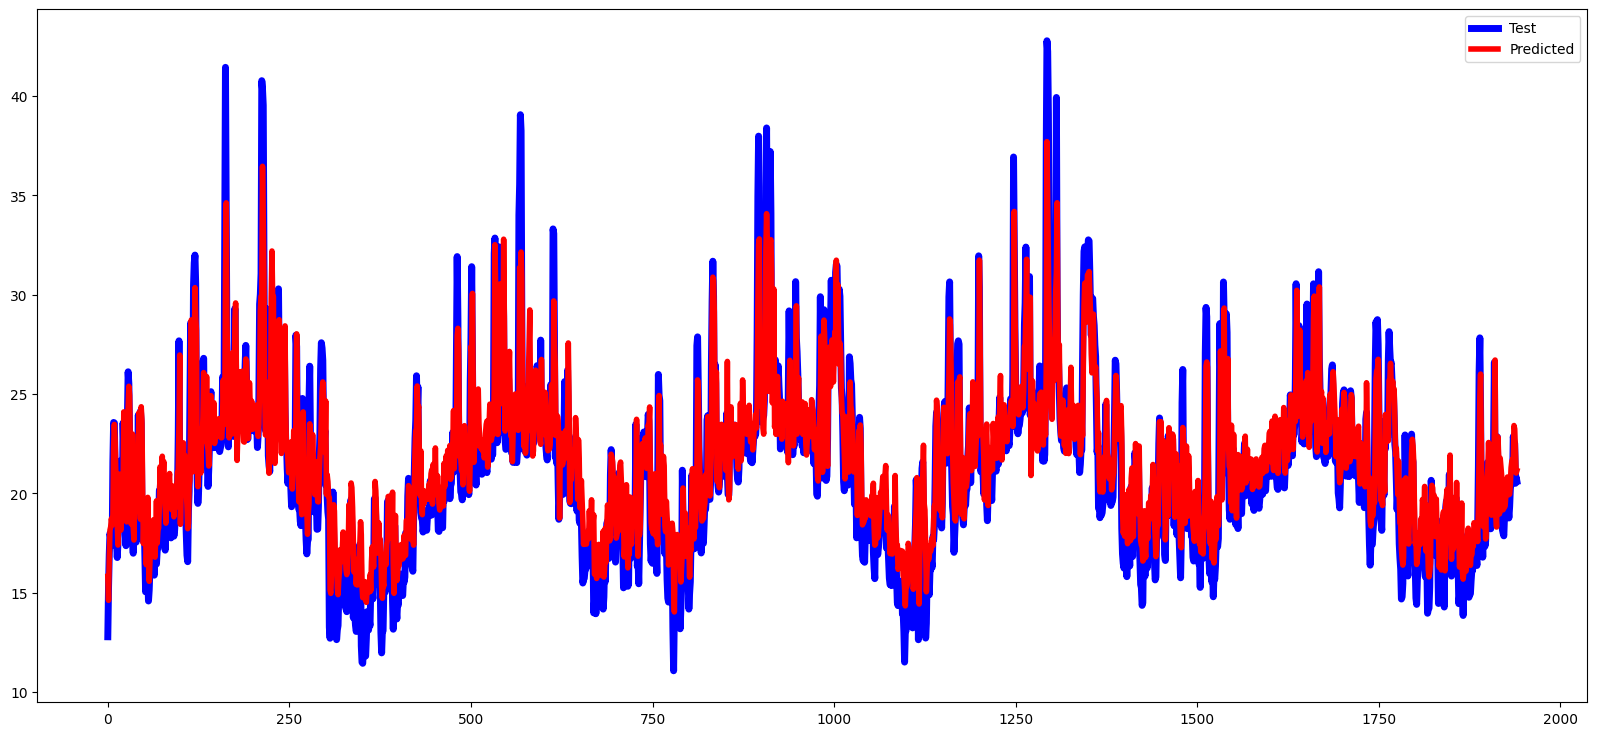

In [49]:
plt.figure(figsize=(20,9))
plt.plot(Ytesting , 'blue', linewidth=5)
plt.plot(predict,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Ytesting, predict)

4.4342995503554015